In [1]:
import yfinance as yf 
import pandas as pd
import numpy as np
from datetime import datetime

from matplotlib import pylab as plt 

/opt/anaconda3/lib/python3.7/site-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [2]:
def rolling_z(data,lookback):
    mean = data.rolling(lookback).mean()
    std = data.rolling(lookback).std()
    z_score = (data - mean)/std
    return(z_score)

### Backtest of Alex Good macro short vol trade

- buy the dip in the 2 year trend on SPY, GLD and TLT. Equal weight open positions. 

In [3]:
gld_tmp = yf.download('GLD')
spy_tmp = yf.download('SPY')
tlt_tmp = yf.download('TLT')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
assets = pd.concat([gld_tmp['Close'],spy_tmp['Close'],tlt_tmp['Close']], axis = 1)
assets.columns = ['GLD', 'SPY', 'TLT']
assets = assets.dropna()

rets = assets.pct_change(1)


In [5]:
signal_df = rolling_z(assets, 252*2) - rolling_z(assets.pct_change(5), 252)
signal_df = np.sign(signal_df).shift(2)

In [6]:
portf=np.multiply(signal_df,rets)
#portf = portf.dropna()
strat_ret = pd.DataFrame(portf.mean(axis = 1))

####
eval_df = assets.copy()
eval_df['strats'] = (strat_ret +1).cumprod()
eval_df = eval_df.dropna()
eval_df = eval_df.pct_change(1)
eval_df[:1] = 0
eval_df['EW'] = eval_df[['SPY', 'GLD', 'TLT']].mean(axis = 1)
eval_df = (eval_df+1).cumprod()


<AxesSubplot:xlabel='Date'>

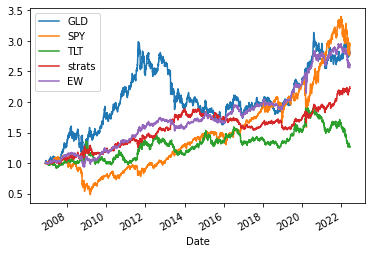

In [7]:
eval_df.plot()

In [10]:
(eval_df.pct_change().mean()/eval_df.pct_change().std())* (np.sqrt(252))

GLD       0.465359
SPY       0.425044
TLT       0.175248
strats    0.530752
EW        0.687185
dtype: float64

<AxesSubplot:xlabel='Date'>

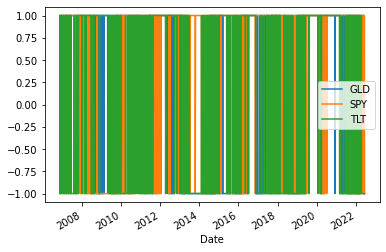

In [9]:
signal_df.dropna().plot()

In [14]:
np.log(1 + eval_df.pct_change()).corr()

,GLD,SPY,TLT,strats,EW
GLD,1.000000,0.033610,0.153719,0.268598,0.730392
SPY,0.033610,1.000000,-0.411068,0.011378,0.518649
TLT,0.153719,-0.411068,1.000000,0.116968,0.328301
strats,0.268598,0.011378,0.116968,1.000000,0.238849
EW,0.730392,0.518649,0.328301,0.238849,1.000000
